# Diseases

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/dev_tut_diseases.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Fdev_tut_diseases.ipynb).
    
</div>

## Overview of Starsim's disease structure

The basic template for modeling a disease in Starsim is the `Disease` class. Much like sims or networks, a `Disease` can be customized by passing in a `pars` dictionary containing parameters. The `Disease` module does lots of different things, but three of the model fundamental are:

- `set_initial_states`, which initializes people into states (e.g. susceptible, infected, recovered)
- `make_new_cases`, which makes new cases (e.g., by finding the susceptible contacts of all infected people and calculating the probability of transmission for each)
- `set_prognoses`, which sets the outcomes for people who get infected (e.g., by setting their date of recovery or death).


## Making your own disease
If you want to make your own disease, you could either inherit from one of the templates in diseases.py, or you could copy the examples and extend them to capture features of the disease that you want to model. For example, suppose you wanted to change the SIR model to an SEIR model (i.e., add an 'exposed' state where people were transmissible but did not yet have symptoms. You might hope that this would be a relatively simple change to make. Here's how it would look:

In [1]:
import starsim as ss
import matplotlib.pyplot as plt

class SEIR(ss.SIR):
    def __init__(self, pars=None, *args, **kwargs):
        super().__init__()
        self.define_pars(
            dur_exp = ss.lognorm_ex(0.5),
        )
        self.update_pars(pars, **kwargs)

        # Additional states beyond the SIR ones 
        self.define_states(
            ss.State('exposed', label='Exposed'),
            ss.FloatArr('ti_exposed', label='TIme of exposure'),
        )
        return

    @property
    def infectious(self):
        return self.infected | self.exposed

    def step_state(self):
        """ Make all the updates from the SIR model """
        # Perform SIR updates
        super().step_state()

        # Additional updates: progress exposed -> infected
        infected = self.exposed & (self.ti_infected <= self.ti)
        self.exposed[infected] = False
        self.infected[infected] = True
        return

    def step_die(self, uids):
        super().step_die(uids)
        self.exposed[uids] = False
        return

    def set_prognoses(self, uids, sources=None):
        """ Carry out state changes associated with infection """
        super().set_prognoses(uids, sources)
        ti = self.ti
        self.susceptible[uids] = False
        self.exposed[uids] = True
        self.ti_exposed[uids] = ti

        # Calculate and schedule future outcomes
        dur_exp = self.pars['dur_exp'].rvs(uids)
        self.ti_infected[uids] = ti + dur_exp
        dur_inf = self.pars['dur_inf'].rvs(uids)
        will_die = self.pars['p_death'].rvs(uids)        
        self.ti_recovered[uids[~will_die]] = ti + dur_inf[~will_die]
        self.ti_dead[uids[will_die]] = ti + dur_inf[will_die]
        return
    
    def plot(self):
        """ Update the plot with the exposed compartment """
        with ss.options.context(jupyter=False):
            fig = super().plot()
            ax = plt.gca()
            res = self.results.n_exposed
            ax.plot(res.timevec, res, label=res.label)
            plt.legend()
        return ss.return_fig(fig)

The new class includes the following main changes:

1. In `__init__` we added the extra pars and states needed for our model
2. We defined `infectious` to include both infected and exposed people - this means that we can just reuse the existing logic for how the SIR model handles transmission
3. We updated `update_pre` and `update_death` to include changes to the `exposed` state 
4. We rewrote `set_prognoses` to include the new exposed state.


Here's how it would look in practice:

Initializing sim with 10000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%


  Running 2010.0 (10/51) (0.24 s)  ••••———————————————— 22%


  Running 2020.0 (20/51) (0.51 s)  ••••••••———————————— 41%


  Running 2030.0 (30/51) (0.72 s)  ••••••••••••———————— 61%


  Running 2040.0 (40/51) (0.95 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (1.13 s)  •••••••••••••••••••• 100%



Figure(896x672)


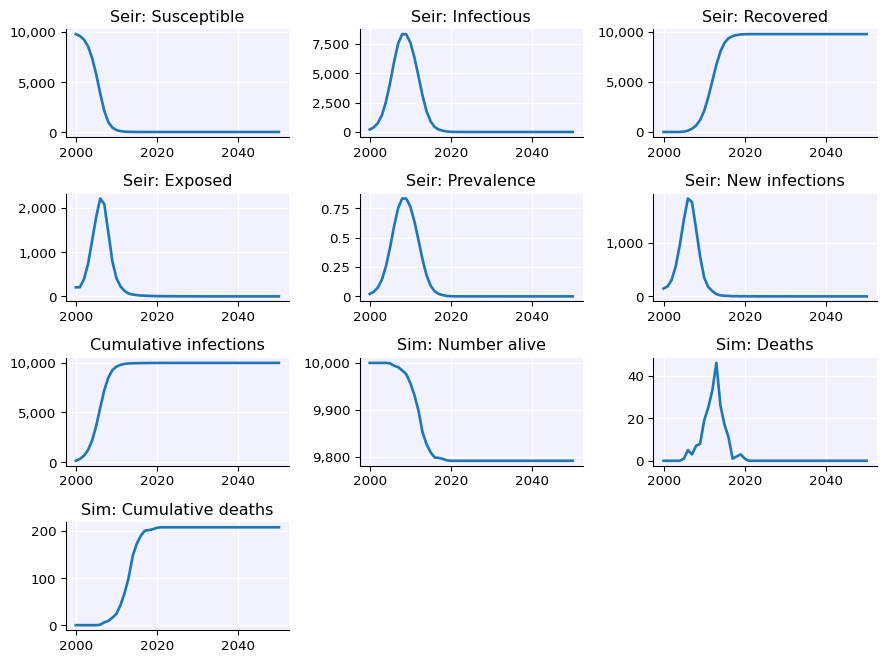

Figure(672x480)


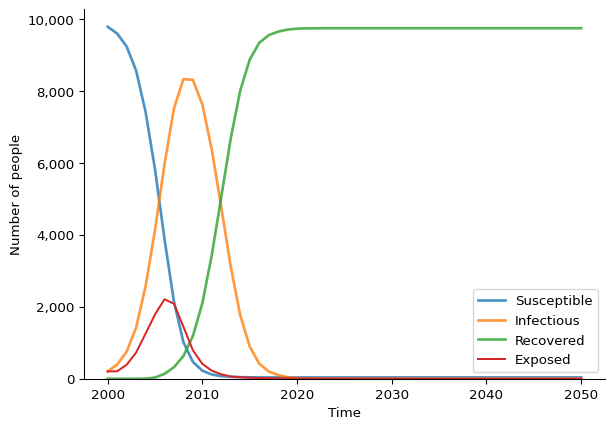

In [2]:
seir = SEIR()
sim = ss.Sim(diseases=seir, networks='random')
sim.run()
sim.plot()
sim.diseases.seir.plot()